**Pair - Modulo 3 - 12-03-2025 - Repaso Pipeline (en vez de ETL II)**

**Modulo 3 - Repaso - Pipeline**

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

from src import soporte_correlacion as sp_corr

# Ver todo el contenido de la columna (que no se corte el url ;) 
pd.set_option('display.max_colwidth', None)

**precios_productos**

In [2]:
# Cargar archivo - Precios
df_precios = pd.read_csv("files/precios_productos.csv", index_col = 0)
df_precios.head()

,price,reference_price,product_id,reference_unit,insert_date
6837303,"0,7","0,7",9b1d806ddaed2a3b4c842c361e9171a8,ud,2022-06-08 00:00:00
5137438,"3,19","10,63",baf038a3f001812899adb8beaf4e0ec7,kg,2022-02-10 00:00:00
6005999,"3,99","15,96",ca2fc753e5ea44e8c95888983c1dafe1,l,2022-04-11 00:00:00
6995217,"3,39","5,22",48c959cc94d6d82d1151189b2abe9e83,l,2022-06-19 00:00:00
5760664,"2,79","0,47",8904722366039ba8f147e2e75a5d1ce1,ud,2022-03-25 00:00:00


In [4]:
df_precios.shape

(1000000, 5)

In [5]:
df_precios.dtypes
# OBSERVATION: prices are objects and have "," -- will need to replace with "."

price              object
reference_price    object
product_id         object
reference_unit     object
insert_date        object
dtype: object

In [6]:
df_precios.info()
# OBSERVATION: price and reference_price have 1 null, reference unit has 1609 nulls

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 6837303 to 5813238
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   price            999999 non-null   object
 1   reference_price  999999 non-null   object
 2   product_id       1000000 non-null  object
 3   reference_unit   998391 non-null   object
 4   insert_date      1000000 non-null  object
dtypes: object(5)
memory usage: 45.8+ MB


In [7]:
df_precios["reference_unit"].isna().sum()

np.int64(1609)

In [8]:
# product_id duplicates?
df_precios['product_id'].duplicated().sum()

np.int64(990531)

In [9]:
df_precios['product_id'].unique()

array(['9b1d806ddaed2a3b4c842c361e9171a8',
       'baf038a3f001812899adb8beaf4e0ec7',
       'ca2fc753e5ea44e8c95888983c1dafe1', ...,
       '2936d24c5540a1e7f0f1790c7ad7ee6a',
       '7f99a886ce8ee22cbe51e77aa41de713',
       'f049c79b0017d244565e90b688caed4d'], shape=(9469,), dtype=object)

In [8]:
df_precios['product_id'].value_counts()

product_id
dec17046c7afb4e5a02252f79738045b    368
6c738b9d8f185c3c1eda643516675a1c    361
17c01da71d8e7a36cf32fd6f34f29625    356
5a0a1bb342bf791eb3296626d0dc88ec    350
25ca80747ce1c7e7ca65445daafb6262    349
                                   ... 
2ac5a1180509afe6b2e3f6655158c2df      1
4b25c3de27904045a711f9a732d2fd1d      1
2936d24c5540a1e7f0f1790c7ad7ee6a      1
7f99a886ce8ee22cbe51e77aa41de713      1
f049c79b0017d244565e90b688caed4d      1
Name: count, Length: 9469, dtype: int64

In [10]:
# REPLACE , to . and str to float
for col in ['price', 'reference_price']:
    df_precios[col] = df_precios[col].str.replace(',', '.', regex=False).astype(float)

In [11]:
df_precios[['price', 'reference_price']].head()

,price,reference_price
6837303,0.70,0.70
5137438,3.19,10.63
6005999,3.99,15.96
6995217,3.39,5.22
5760664,2.79,0.47


In [12]:
df_precios.dtypes

price              float64
reference_price    float64
product_id          object
reference_unit      object
insert_date         object
dtype: object

**productos_dia**

In [16]:
# Cargar archivo - Productos
df_productos = pd.read_csv("files/productos_dia.csv", index_col = 0)
df_productos.sample(4)

,url,supermarket,name,description,product_id
3599752,https://www.dia.es/compra-online/cuidado-personal/bano-e-higiene-personal/cuidado-del-cabello/p/155651,dia-es,NATUR VITAL mascarilla capilar color cabellos castaños bote 300 ml,NaN,9b9acd78c389d7b435c0374f99665007
3030581,https://www.dia.es/compra-online/bebidas/cervezas/especiales/p/189330,dia-es,LA COLORADA cerveza 1906 red vintage pack 6 botellas 33 cl,NaN,454515ac5e00e4ff2f41e57a77832ab5
2374624,https://www.dia.es/compra-online/despensa/sal-y-especias/p/107991,dia-es,DANI pimienta negra molida frasco 45 gr,NaN,de76095485305328c3481f9533e010bb
2364888,https://www.dia.es/compra-online/cuidado-del-hogar/utensilios-de-limpieza/p/23008,dia-es,DIA guantes flocados talla 8 bolsa 1 par,NaN,3399294c8662733d8622dedcc9109205


In [14]:
df_productos.shape

(11494, 5)

In [15]:
df_productos.dtypes
# OBSERVATION: Description is float64 and all are NaN (100%) - DROP Description??

url             object
supermarket     object
name            object
description    float64
product_id      object
dtype: object

In [17]:
df_productos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11494 entries, 2362486 to 7838355
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   url          11494 non-null  object 
 1   supermarket  11494 non-null  object 
 2   name         11494 non-null  object 
 3   description  0 non-null      float64
 4   product_id   11494 non-null  object 
dtypes: float64(1), object(4)
memory usage: 538.8+ KB


In [18]:
df_productos["description"].value_counts(dropna=False, normalize=True)*100

description
NaN    100.0
Name: proportion, dtype: float64

In [19]:
df_productos["description"].isna().sum()

np.int64(11494)

In [20]:
# product_id duplicates?
df_productos['product_id'].duplicated().sum()

np.int64(1998)

In [21]:
# rows involved in duplication
df_productos[df_productos['product_id'].duplicated(keep=False)].sort_values('product_id').head()

,url,supermarket,name,description,product_id
2811348,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
4525857,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo MSC bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
2366218,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4019287,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4917259,https://www.dia.es/compra-online/platos-preparados/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de


In [22]:
# Check for DUPLICATE Rows
df_productos['product_id'].duplicated().sum()
# OBSERVATIONS: 1998 duplicates total

np.int64(1998)

In [23]:
# See the DUPLICATES (all, including keepers)
df_productos[df_productos['product_id'].duplicated(keep=False)].sort_values('product_id')

,url,supermarket,name,description,product_id
2811348,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
4525857,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo MSC bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
2366218,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4019287,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4917259,https://www.dia.es/compra-online/platos-preparados/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
...,...,...,...,...,...
2366348,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/3374,dia-es,DIA MARI MARINERA palitos de surimi envase 450 gr,NaN,ff73c5c247c412bda93ddad898b5b075
5846274,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/155710,dia-es,FINISH Quantum lavavajillas máquina powerball en cápsulas bolsa 18 + 10 uds,NaN,ffaa6aa7fa9766dc8cb93c12656fd7f7
4526080,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/155710,dia-es,FINISH Quantum max lavavajillas powerball bolsa 18 + 9 uds,NaN,ffaa6aa7fa9766dc8cb93c12656fd7f7
2363833,https://www.dia.es/compra-online/despensa/aceites-vinagres-y-alinos/aceites/p/227121,dia-es,DIA LA ALMAZARA DEL OLIVAR aceite de oliva virgen garrafa 3 lt,NaN,ffbcfa85da8287e5677b795de20b226c


In [ ]:
# Show full content of strings (luego he copiado esto y subido arriba con los imports)
pd.set_option('display.max_colwidth', None)

# View a few sample duplicates with full URLs
df_productos[df_productos['product_id'].duplicated(keep=False)].sort_values('product_id').head(10)


,url,supermarket,name,description,product_id
2811348,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
4525857,https://www.dia.es/compra-online/congelados/pescado-y-marisco/p/26442,dia-es,DIA MARI MARINERA medallones de merluza del cabo MSC bolsa 475 gr,NaN,0008afbaae96e6003d71de151a2ec67b
2366218,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4019287,https://www.dia.es/compra-online/despensa/arroz-y-legumbres/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
4917259,https://www.dia.es/compra-online/platos-preparados/legumbres/p/49694,dia-es,DIA AL PUNTO cocido madrileño lata 440 gr,NaN,000d481c0e60b87db07bd8e395e505de
2372848,https://www.dia.es/compra-online/despensa/lacteos-y-huevos/leche/p/225278,dia-es,DIA LACTEA leche entera sin lactosa envase 1 lt,NaN,00138f26abf82cf78fce782e623f7df3
2374050,https://www.dia.es/compra-online/despensa/lacteos-y-huevos/leche/p/225278P6,dia-es,DIA LACTEA leche entera sin lactosa envase 1 lt PACK 6,NaN,00138f26abf82cf78fce782e623f7df3
3550223,https://www.dia.es/compra-online/frescos/carne/cerdo/p/159422,dia-es,VALLINA compango asturiano bandeja 250 gr,NaN,002673ed792f107a2ea67cdc56029182
2374911,https://www.dia.es/compra-online/al-dia/carne/cerdo/p/159422,dia-es,VALLINA compango asturiano bandeja 250 gr,NaN,002673ed792f107a2ea67cdc56029182
3901129,https://www.dia.es/compra-online/despensa/desayunos-y-dulces/galletas/p/231781,dia-es,DIA GALLETECA mini galletas rellenas de chocolate caja 176 gr,NaN,009af6d8c32d5a7082665322fcb02e09


**Extraer datos del URL: Categoria y Subcategoria -- FALTA REMATAR**

In [ ]:
# TERRIBLE ChatGPT - COMPLICADISIMO con Regex

# EXTRACT clean category / subcategory:
# Extract category and subcategory (skipping top-level folder)
parts = df_productos['url'].str.extract(r'compra-online/(?:[^/]+/)?([^/]+)/([^/]+)/p/')
parts.columns = ['category', 'subcategory']

# Add these to df_productos
df_productos = pd.concat([df_productos, parts], axis=1)

In [ ]:
# OTRA OPCION MAS DIRECTA :P (igual no funciona porque no son todos del mismo tamano/largo)
# str.split -- APPLY - evaluar longitud del string
# https://www.dia.es/compra-online/frescos/charcuteria-y-quesos/quesos/p/287876

In [ ]:
# UN ejemplo de como llegar a la solucion (Cesar) -- Editarlo/Adaptarlo
def sacar_categoria (url):
    
    if "bulto-mixto" in url or "peso" in url or "caducidad" in url or "clasificacion-de-categorias" in url:
        return url.split("/")[5], url.split("/")[6]
    else:
        return url.split("/")[4], url.split("/")[5]

In [ ]:
# OTRO ejemplo de como llegar a la solucion (Cesar) -- Editarlo/Adaptarlo
def sacar_info(x):
    if "al-dia" in x:
        return "frescos", x.split("/")[5]

    elif "bulto-mixto" in x or "peso" in x or "caducidad" in x or "clasificacion-de-categorias" in x:
        return x.split("/")[5], x.split("/")[6]
        
    else:
        return x.split("/")[4], x.split("/")[5]

In [26]:
df_productos.tail(4)

,url,supermarket,name,description,product_id,category,subcategory
7781465,https://www.dia.es/compra-online/frescos/charcuteria-y-quesos/quesos/p/287876,dia-es,WYKE FARMS queso cheddar extra mature pieza 200 gr,NaN,f25e7805007523eaa1c524f23c232c26,charcuteria-y-quesos,quesos
7798126,https://www.dia.es/compra-online/frescos/frutas/frutas-de-temporada/p/27018,dia-es,Ciruela claudia reina cesta 500 gr,NaN,8bfb10b66a10e5c79b5a692af80ea9cc,frutas,frutas-de-temporada
7799546,https://www.dia.es/compra-online/cuidado-personal/bano-e-higiene-personal/cuidado-del-cabello/p/283797,dia-es,HERBAL ESSENCES mascarilla reparadora con aceite argán tarro 450 ml,NaN,01af8bbca86863c1c85df068d136ac11,bano-e-higiene-personal,cuidado-del-cabello
7838355,https://www.dia.es/compra-online/frescos/carne/cerdo/p/32912,dia-es,SELECCIÓN DE DIA chistorra de navarra pieza 220 gr,NaN,1fd60bcc17c04fc705ea7515dbd42034,carne,cerdo


In [ ]:
# NEW DataFrame with DROP duplicate rows with 'product_id', KEEP LAST - name is longer (more descriiptive)
df_products_unique = df_productos.drop_duplicates(subset='product_id', keep='last') 
# Se podria investigar mas... pero hoy no ;)

In [ ]:
# LEFT JOIN on "product_id" -- COMENTARIOS de un JOIN y resultado inicial que luego se borro
# Initially joined immediately, saw 25% dupes so backtracked to check each df for dupes
# df = df_precios.merge(df_productos, on="product_id", how="left")

#df.shape
# DataFrame GREW - must be some duplicates

#df.isnull().sum()
# OBSERVATIONS: description is null for all rows 1264512 & reference_unit has 1616 nuls

In [28]:
df_products_unique.shape

(9496, 7)

In [29]:
df_products_unique.head()

,url,supermarket,name,description,product_id,category,subcategory
2362486,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/181184,dia-es,MISTOL lavavajillas mano original botella 900 ml,NaN,9e2fda45e63337294f2a604178823026,cuidado-del-hogar,lavavajillas
2362487,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/223986,dia-es,DIA lavavajillas máquina premium todo en uno en cápsulas caja 35 uds,NaN,244994c762813d38881cb118742152a2,cuidado-del-hogar,lavavajillas
2362489,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/257617,dia-es,FAIRY lavavajillas máquina platinum plus limón bolsa 18 cápsulas,NaN,2cd7ea87b1963adb51d8e1295f6c14d3,cuidado-del-hogar,lavavajillas
2362501,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/211650,dia-es,FAIRY lavavajillas mano concentrado aloe vera botella 500 ml,NaN,4abac3d30922f81012d7ae0c2cd955f2,cuidado-del-hogar,lavavajillas
2362502,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/209779,dia-es,DIA lavavajillas mano super concentrado botella 750 ml,NaN,bfa1e29fbdded3b51541e3c6ebb4b8ac,cuidado-del-hogar,lavavajillas


In [30]:
df_products_unique.drop(columns='description', inplace=True)
# DROP "description" -- all NaNs

In [31]:
df_products_unique.head(2)

,url,supermarket,name,product_id,category,subcategory
2362486,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/181184,dia-es,MISTOL lavavajillas mano original botella 900 ml,9e2fda45e63337294f2a604178823026,cuidado-del-hogar,lavavajillas
2362487,https://www.dia.es/compra-online/cuidado-del-hogar/lavavajillas/p/223986,dia-es,DIA lavavajillas máquina premium todo en uno en cápsulas caja 35 uds,244994c762813d38881cb118742152a2,cuidado-del-hogar,lavavajillas


**Join dataframes**

In [32]:
# JOIN (Left) the clean DFs:
df = df_precios.merge(df_products_unique, on="product_id", how="left")

In [33]:
df.head(3)

,price,reference_price,product_id,reference_unit,insert_date,url,supermarket,name,category,subcategory
0,0.70,0.70,9b1d806ddaed2a3b4c842c361e9171a8,ud,2022-06-08 00:00:00,https://www.dia.es/compra-online/cuidado-del-hogar/utensilios-de-limpieza/p/270115,dia-es,DIA SUPER PACO guantes satinados talla S bolsa 1 par,cuidado-del-hogar,utensilios-de-limpieza
1,3.19,10.63,baf038a3f001812899adb8beaf4e0ec7,kg,2022-02-10 00:00:00,https://www.dia.es/compra-online/despensa/desayunos-y-dulces/cereales/p/37838,dia-es,KELLOGGS cereales special k con frutas rojas caja 300 gr,desayunos-y-dulces,cereales
2,3.99,15.96,ca2fc753e5ea44e8c95888983c1dafe1,l,2022-04-11 00:00:00,https://www.dia.es/compra-online/cuidado-personal/cuidado-corporal/crema-solar/p/274490,dia-es,DIA IMAQE leche solar infantil spf 50+ tubo 250 ml,cuidado-corporal,crema-solar


Imagina que eres un analista de datos para el supermercado Día, y te proporcionan los dtoa de los productos y sus precios.

Para ello podemos hacer una análisis de los datos para obtener información relevante, sobre:

1. Identificar la categoría y subcategoría de cada producto

In [ ]:
df_products_unique[['product_id', 'category', 'subcategory']].sample(4)

,product_id,category,subcategory
2368608,bf2c43c975e09c319b25bfc560b08af5,salsas,tomate
3122774,0b03ee81683559838eb059e17323b91b,despensa,aperitivos
2365045,86ccfff417d74565b3d930bccfb2e025,bebidas,bebidas-isotonicas-y-energeticas
2634356,b66bd8106fe0b454320197ac39cdc782,bano-e-higiene-personal,geles-de-duchas-y-esponjas


In [ ]:
# Comprobaciones --- repensar categoria/subcategoria :S
df_products_unique.loc[
    df_products_unique['product_id'] == '0b03ee81683559838eb059e17323b91b',
    ['product_id', 'category', 'subcategory', 'url']
]

,product_id,category,subcategory,url
3122774,0b03ee81683559838eb059e17323b91b,despensa,aperitivos,https://www.dia.es/compra-online/despensa/aperitivos/p/223839


In [ ]:
# see above used regex to extract the last two before /p/ in list (seemed like category/subcategory to me!)
# EXTRACT clean category / subcategory:
# Extract category and subcategory (skipping top-level folder)
# parts = df_productos['url'].str.extract(r'compra-online/(?:[^/]+/)?([^/]+)/([^/]+)/p/')
# parts.columns = ['category', 'subcategory']

2. ¿Qué categoría es la que vende más productos?

In [36]:
# desayunos-y-dulces
(df_products_unique["category"].value_counts(dropna=False, normalize=True)*100)

category
desayunos-y-dulces               13.005476
bano-e-higiene-personal          12.921230
cuidado-del-hogar                 8.256108
cuidado-corporal                  6.034120
cuidado-personal                  5.707666
charcuteria-y-quesos              4.959983
lacteos-y-huevos                  4.780960
despensa                          4.496630
bebidas                           4.496630
congelados                        4.264954
bebe                              2.948610
conservas                         2.917018
mascotas                          2.232519
cuidado-del-hogar-de-limpieza     2.000842
vino                              1.916596
platos-preparados                 1.716512
pan                               1.632266
cervezas                          1.590143
carne                             1.379528
verduras-y-hortalizas             1.316344
salsas                            1.305813
frutas                            1.263690
pastas-harinas-y-masas            1.126790
du

3. Dentro de cada categoría, ¿qué subcategorías son más populares?

In [ ]:
# GROUPBY "category"
df_products_unique.groupby('category')['subcategory'].value_counts()

category                   subcategory           
aceites-vinagres-y-alinos  aceites                    53
                           vinagres-y-alinos          20
alcoholes                  ginebra                    26
                           whisky                     26
                           vermouth                   17
                                                    ... 
verduras-y-hortalizas      espinacas-y-alcachofas      1
vino                       tinto                     122
                           blanco                     46
                           rosado                      8
                           generoso-y-dulce            6
Name: count, Length: 179, dtype: int64

In [ ]:
df_products_unique.groupby('category')['subcategory'].value_counts().groupby(level=0).head(1)
#GROUPBY "category" and again "category" for the top one (value_counts automatically does desc order)

# if I wanted a PRETTY output , convert to DF, reset index, display()

category                       subcategory                
aceites-vinagres-y-alinos      aceites                         53
alcoholes                      ginebra                         26
arroz-y-legumbres              legumbres                       51
bano-e-higiene-personal        cuidado-del-cabello            477
bebe                           cuidado-del-bebe               115
bebidas                        refrescos                      158
bodega                         espumosos                       40
carne                          cerdo                           42
cervezas                       especiales                      76
charcuteria-y-quesos           quesos                         198
cocina-internacional           mejicana                        22
congelados                     helados                        172
conservas                      conservas-de-pescado           146
cuidado-corporal               crema-facial                   185
cuidado-del-hogar

In [ ]:
products_top_cat = df_products_unique.groupby('category')['subcategory'].value_counts().groupby(level=0).head(1).rename("count").reset_index()

In [ ]:
display(products_top_cat)

,category,subcategory,count
0,aceites-vinagres-y-alinos,aceites,53
1,alcoholes,ginebra,26
2,arroz-y-legumbres,legumbres,51
3,bano-e-higiene-personal,cuidado-del-cabello,477
4,bebe,cuidado-del-bebe,115
5,bebidas,refrescos,158
6,bodega,espumosos,40
7,carne,cerdo,42
8,cervezas,especiales,76
9,charcuteria-y-quesos,quesos,198


4. ¿Qué categoría es la que tiene los precios más altos? ¿y los mínimos? ¿Cuál es su media?

In [ ]:
# Below is AI giving the clean and print one...

In [50]:
# Group by category and calculate min, max, and mean prices
category_price_stats = df.groupby('category')['price'].agg(['min', 'max', 'mean'])

# Sort to find:
most_expensive_category = category_price_stats['max'].idxmax()
cheapest_category = category_price_stats['min'].idxmin()
average_prices = category_price_stats['mean'].sort_values(ascending=False)

In [51]:
print(f"✅ Categoría con precio máximo más alto: {most_expensive_category} ({category_price_stats.loc[most_expensive_category, 'max']:.2f} €)")
print(f"✅ Categoría con precio mínimo más bajo: {cheapest_category} ({category_price_stats.loc[cheapest_category, 'min']:.2f} €)")
print("\n📊 Media de precios por categoría:")
print(average_prices.round(2))


✅ Categoría con precio máximo más alto: charcuteria-y-quesos (289.00 €)
✅ Categoría con precio mínimo más bajo: dulces-de-navidad (0.08 €)

📊 Media de precios por categoría:
category
alcoholes                        11.49
licores                           8.36
cuidado-corporal                  6.69
charcuteria-y-quesos              5.54
aceites-vinagres-y-alinos         4.97
pescado-y-marisco                 4.94
vino                              4.84
bebe                              4.68
mascotas                          4.55
cuidado-personal                  4.29
carne                             4.14
bano-e-higiene-personal           4.06
cuidado-del-hogar                 3.88
dieteticos                        3.24
congelados                        3.07
platos-preparados                 2.61
bodega                            2.58
cuidado-del-hogar-de-limpieza     2.52
conservas                         2.40
dulces-de-navidad                 2.36
desayunos-y-dulces                2.3

In [ ]:
# df.groupby('category')['price'].agg(['min', 'max', 'mean']).sort_values('mean', ascending=False)

,min,max,mean
category,,,
alcoholes,1.69,33.59,11.489820
licores,1.89,13.99,8.361365
cuidado-corporal,0.65,41.99,6.694109
charcuteria-y-quesos,0.55,289.00,5.544470
aceites-vinagres-y-alinos,0.49,26.99,4.968854
pescado-y-marisco,1.25,33.58,4.942214
vino,0.95,26.25,4.835258
bebe,0.75,25.74,4.679905
mascotas,0.37,28.99,4.545073


In [45]:
df.groupby('category')['price'].max().sort_values(ascending=False).head(1)

category
charcuteria-y-quesos    289.0
Name: price, dtype: float64

In [47]:
df.groupby('category')['price'].min().sort_values().head(1)

category
dulces-de-navidad    0.08
Name: price, dtype: float64

In [49]:
df.groupby('category')['price'].mean()


category
aceites-vinagres-y-alinos         4.968854
alcoholes                        11.489820
arroz-y-legumbres                 1.730430
bano-e-higiene-personal           4.064108
bebe                              4.679905
bebidas                           1.610629
bodega                            2.581724
carne                             4.135705
cervezas                          2.308636
charcuteria-y-quesos              5.544470
cocina-internacional              1.816107
congelados                        3.066610
conservas                         2.399215
cuidado-corporal                  6.694109
cuidado-del-hogar                 3.877597
cuidado-del-hogar-de-limpieza     2.518014
cuidado-personal                  4.293468
desayunos-y-dulces                2.352879
despensa                          1.642804
dieteticos                        3.243406
dulces-de-navidad                 2.358549
frutas                            2.198801
lacteos-y-huevos                  1.964877
li

**Análisis de precios y productos**

- ¿Existen productos con precios fuera de lo común (outliers)?

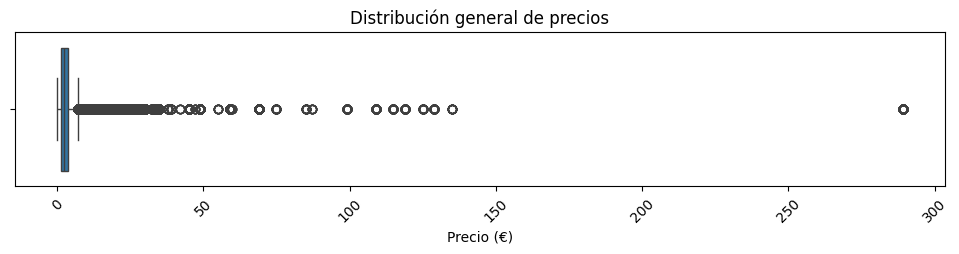

In [54]:
plt.figure(figsize=(12, 2))  # Make it wider and not too tall
sns.boxplot(x=df['price'])
plt.title("Distribución general de precios")
plt.xlabel("Precio (€)")
plt.xticks(rotation=45)
plt.show()

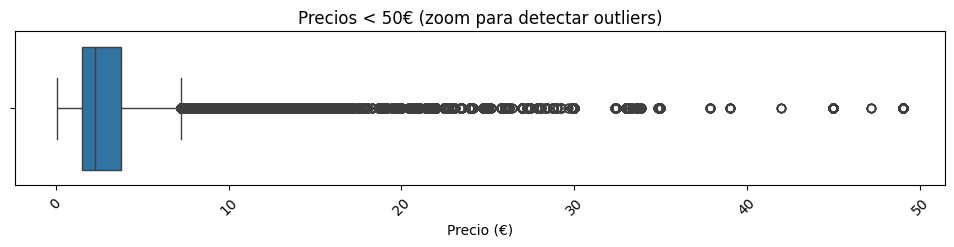

In [55]:
plt.figure(figsize=(12, 2))
sns.boxplot(x=df[df['price'] < 50]['price'])
plt.title("Precios < 50€ (zoom para detectar outliers)")
plt.xlabel("Precio (€)")
plt.xticks(rotation=45)
plt.show()

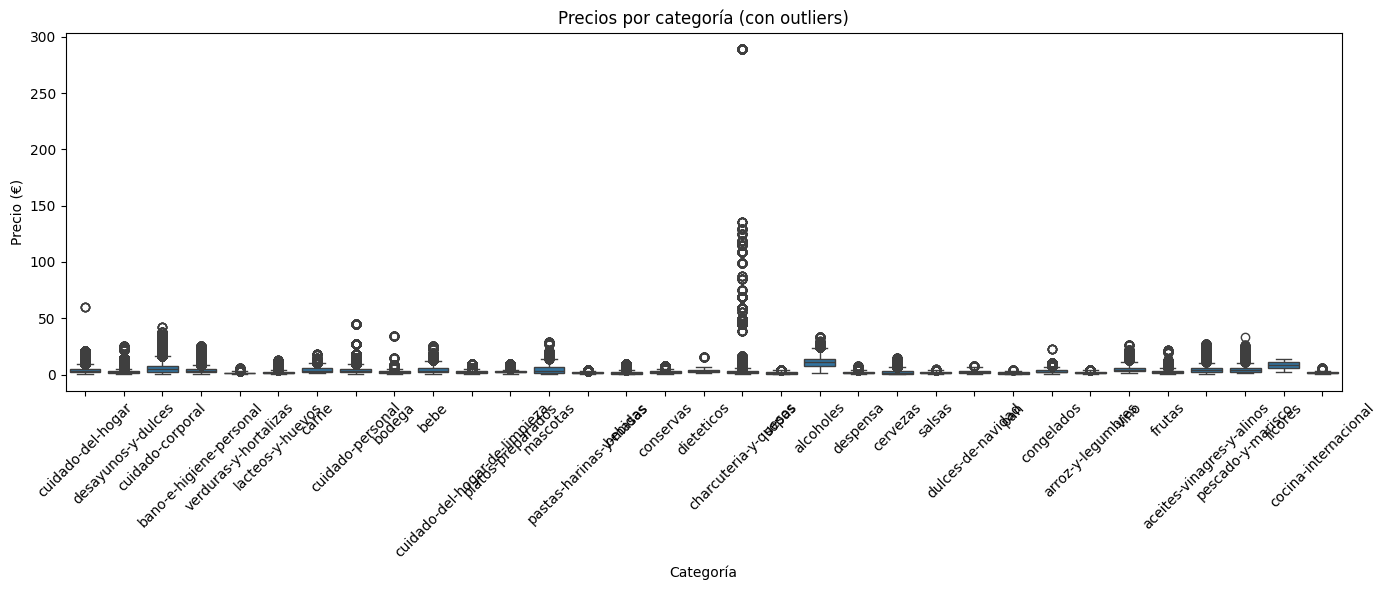

In [56]:
plt.figure(figsize=(14, 6))  # wider and taller
sns.boxplot(data=df, x='category', y='price')
plt.title("Precios por categoría (con outliers)")
plt.xlabel("Categoría")
plt.ylabel("Precio (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

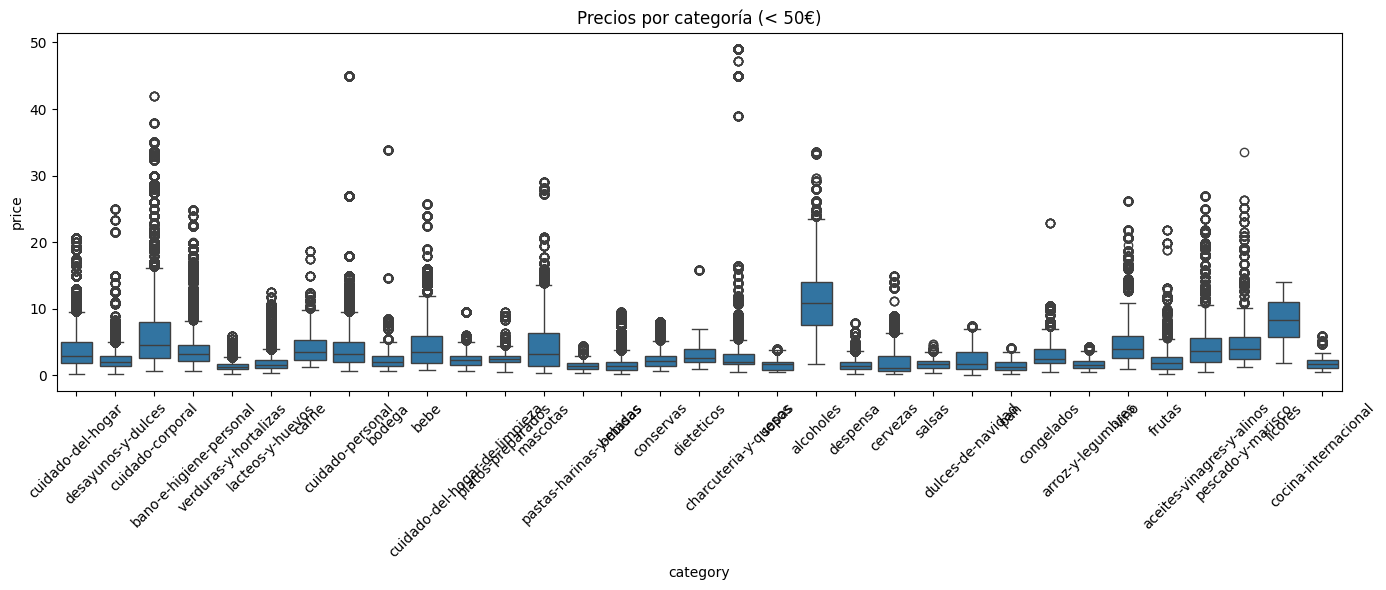

In [57]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[df['price'] < 50], x='category', y='price')
plt.title("Precios por categoría (< 50€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- ¿Cuántos productos tienen un precio superior al precio de referencia?

- ¿Qué categorías de productos tienen la mayor y menor variación de precios?

- ¿Cómo varían los precios de los productos a lo largo del tiempo?

**Análisis de productos**

- ¿Qué productos tienen más registros de precios?

- ¿Cuántos productos distintos hay en el dataset?

- ¿Existen productos en el dataset de precios que no tienen información en el dataset de productos?

**Relación entre precios y unidades de medida**

- ¿Cuál es el precio medio por unidad de referencia de cada producto?

*Recuerda que para realizar este análisis, deberás unir los dos conjuntos de datos de la forma más eficiente. Y realizar un exploración y limpieza de los datos.*

**Los datos**
Para este repaso usaremos dos conjuntos de datos, estos son:

`productos_dia.csv`: en el que podremos encontrar una serie de productos, y sus precios. Las columnas que hay son:

- **url**: Es el enlace URL asociado al producto en el sitio web de un supermercado específico. Por ejemplo, el primer registro tiene una URL que probablemente lleva a la página del producto en el sitio web de DIA.

- **supermarket**: Es el nombre o identificador del supermercado. Por ejemplo, "dia-es" puede referirse al supermercado DIA.

- **name**: Es el nombre del producto. Por ejemplo, el primer registro describe un producto llamado "MISTOL lavavajillas mano original botella 900 ml".

- **description**: Proporciona una descripción detallada del producto. Por ejemplo, el segundo registro describe un producto llamado "DIA lavavajillas máquina premium todo en uno e...".

- **product_id**: Es un identificador único para cada producto. Sin embargo, en estos casos específicos, parece haber valores faltantes (NaN) en esta columna. Cada valor único en esta columna representa un producto diferente.

`precios_productos.csv`: en el que encontramos todos los productos que han comprando y vendido en el supermercado desde el 2021. Las columnas que tenemos son:

- **price**: Este es el precio del producto en la moneda especificada. Por ejemplo, el primer registro tiene un precio de 0,7 en alguna moneda no especificada.

- **reference_price**: Se refiere al precio de referencia del producto. Podría ser el precio original, el precio de venta sugerido u otro precio relevante asociado al producto. Por ejemplo, el segundo registro tiene un precio de referencia de 10,63.

- **product_id**: Es un identificador único para cada producto. Cada valor único en esta columna representa un producto diferente. Por ejemplo, "9b1d806ddaed2a3b4c842c361e9171a8" es el ID de un producto.

- **reference_unit**: Indica la unidad de medida utilizada para el precio de referencia del producto. Por ejemplo, "ud" podría representar unidades (cada unidad), "kg" kilogramos, o "l" litros.

- **insert_date**: Es la fecha en la que se insertó este registro en el DataFrame. Por ejemplo, el primer registro fue insertado el 8 de junio de 2022 a las 00:00:00.